# Normal 02b - Mercury in fish - Stan

_Adapted from Josep Fortiana (2023-03-13) by Jordi Abante (2024-03-14)_

## Data description

Mercury concentrations in parts per million (ppm) measured on tissue samples from  21 common carp specimens caught at a particular site.

Data by courtesy of Kate Cowles, used in her book, _Applied Bayesian Statistics_ (2013), Chapters 6-8.

After log-transforming the data, the observed quantities are:

In [1]:
# Logs of concentration of mercury in fish tissue
x<-c(-2.526, -1.715, -1.427, -2.12, -2.659, -2.408, -3.219, -1.966,-2.526, -1.833,
    -2.813, -1.772, -2.813, -2.526, -3.219, -2.526,-2.813, -2.526, -3.507, -2.996, -3.912)

In [2]:
summary(x)
n<-length(x)
n

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -3.912  -2.813  -2.526  -2.563  -2.120  -1.427 

[1] 21

In [3]:
# Empirical mean and variance (the variance both with and without the correction factor)
xm<-mean(x)
s2tilde<-var(x)
s2<-sum((x-xm)^2)/n
round(c(xm,s2tilde,s2),4)

[1] -2.5630  0.3854  0.3670

$$
	\overline{x}=-2.5630,\quad \widetilde{s}{}^2=0.3854,\quad s^{2}=0.3670.
$$

## Statistics on the precision $\psi=1/\sigma^{2}$, when the mean is known

Assume, for the sake of the exercise, that the mean is known to be $\mu=-2.5$. 

Then, the variance must be computed with:

$$
	s^{2}(\mu)=\frac{1}{n}\textstyle\sum_{i=1}^{n}(x_{i}-\mu)^{2}.
$$

In [4]:
mu<--2.5
x0<-x-mu
s20<-sum(x0^2)/n
round(s20,4)
#[1] 0.371

[1] 0.371

## Conjugate prior

Our prior pdf for the precision is $\psi\sim\textrm{Gamma}(\alpha,\beta)$, where $\alpha$ and $\beta$ will be determined, if possible, from any prior information available.

## Computing prior $\alpha$ and $\beta$ from quantiles

Assume that an expert on mercury contamination told us:

>With $95\%$ certainty the (true) variance is between $q_{0.025}=0.25$ and $q_{0.975}=0.75$ (we assume the remaining 0.05 is symmetrically distributed both sides). 

That is,

$$
    0.95=P(q_{0.025}<\sigma^{2}<q_{0.975})=P(\frac{1}{q_{0.975}}<\psi<\frac{1}{q_{0.025}}).
$$

We recall that a $\textrm{Gamma}(\alpha,\beta)$ is a **scaled $\chi^{2}(k)$.**

Precisely, if $\psi\sim\textrm{Gamma}(\alpha,\beta)$ then $Z\equiv 2\,\beta\,\psi\sim\chi^{2}(k)$, where $k\equiv 2\,\alpha$.

Multiplying the above inequalities by $2\,\beta$,

$$
    0.95=P\big(a\equiv 2\,\beta\cdot \frac{1}{q_{0.975}}<Z< b\equiv2\,\beta\cdot\frac{1}{q_{0.025}}\big).
$$

Since, for a given $k=2\,\alpha$, `a=qchisq(0.025,2*alpha)`  and `b=qchisq(0.975,2*alpha)`, and

$$
    \beta=\dfrac{a\cdot q_{0.975}}{2}=\dfrac{b\cdot q_{0.025}}{2},
$$

we can use this equality as an equation to determine $\alpha$. We want $\alpha$ such that both expressions coincide.

In [5]:
q025<-0.25
q975<-0.75
# diff.two.betas will be equal to zero when both expressions giving beta coincide:
diff.two.betas<-function(a,q025=0.25,q975=0.75){
    return(qchisq(0.025,2*a)*q975-qchisq(0.975,2*a)*q025)
    }
A<-uniroot(diff.two.betas,c(1,20))
prior.a<-A$root
#
prior.b<-qchisq(0.025,2*prior.a)*q975/2
round(prior.a,4)
round(prior.b,4)

[1] 13.2148

[1] 5.3087

# Treatment with Stan and `rstan`

In [6]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan,quietly=TRUE)
# Following directions:
# For execution on a local, multicore CPU with excess RAM we recommend calling
# options(mc.cores = parallel::detectCores()).
# To avoid recompilation of unchanged Stan programs, we recommend calling
# rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)
Sys.setenv(LOCAL_CPPFLAGS = '-march=corei7 -mtune=corei7')


rstan version 2.26.13 (Stan version 2.26.1)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Do not specify '-march=native' in 'LOCAL_CPPFLAGS' or a Makevars file



## 01. Simulate from the prior pdf

The `model` block does not contain a likelihood.

In [7]:
modelString.prior = "data {
    real<lower=0> a;     
    real<lower=0> b;      
    }
parameters {
    real<lower=0> psi;
    }
transformed parameters {
    real<lower=0> sigma = inv_sqrt(psi);
    }
model {
    // prior
    psi ~ gamma(a, b); 
    }
"

In [8]:
# Translate model to C++ and compile to DSO:
stanDso.prior <- stan_model(model_code=modelString.prior) 

In [9]:
# Specify data:
prior.a<-13.2148
prior.b<-5.3087
dataList.prior = list(a=prior.a,b=prior.b)

In [10]:
# Generate posterior sample:
stanFit.prior<-sampling(object=stanDso.prior,data=dataList.prior,chains=3,iter=15000,warmup=1500,thin=5)

In [11]:
S.prior<-summary(stanFit.prior)
round(S.prior$summary,4)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
psi,2.5107,0.0078,0.6866,1.3405,2.0161,2.4597,2.9384,4.0205,7722.358,0.9999
sigma,0.6497,0.0011,0.0935,0.4987,0.5834,0.6376,0.7043,0.8637,7825.934,0.9999
lp__,-1.6671,0.0081,0.7139,-3.6814,-1.8276,-1.3942,-1.2157,-1.1635,7758.632,0.9997


### Theoretical prior expectation, variance, sd

In [12]:
Theor.prior.Expectation<-prior.a/prior.b
Theor.prior.variance<-prior.a/prior.b^2
Theor.prior.sd<-sqrt(Theor.prior.variance)
round(Theor.prior.Expectation,4)
round(Theor.prior.variance,4)
round(Theor.prior.sd,4)

[1] 2.4893

[1] 0.4689

[1] 0.6848

In [13]:
# extract prior sample, discard unnecessary attributes to keep just the numbers
psi.prior <- extract(stanFit.prior, 'psi')
sigma.prior <- extract(stanFit.prior, 'sigma')

In [14]:
str(psi.prior)
psi.prior <- unlist(psi.prior, use.names=FALSE)
str(psi.prior)

List of 1
 $ psi: num [1:8100(1d)] 2.67 2.21 2.23 2.16 2.06 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 num [1:8100] 2.67 2.21 2.23 2.16 2.06 ...


In [15]:
str(sigma.prior)
sigma.prior <- unlist(sigma.prior, use.names=FALSE)
str(sigma.prior)

List of 1
 $ sigma: num [1:8100(1d)] 0.612 0.672 0.67 0.68 0.697 ...
  ..- attr(*, "dimnames")=List of 1
  .. ..$ iterations: NULL
 num [1:8100] 0.612 0.672 0.67 0.68 0.697 ...


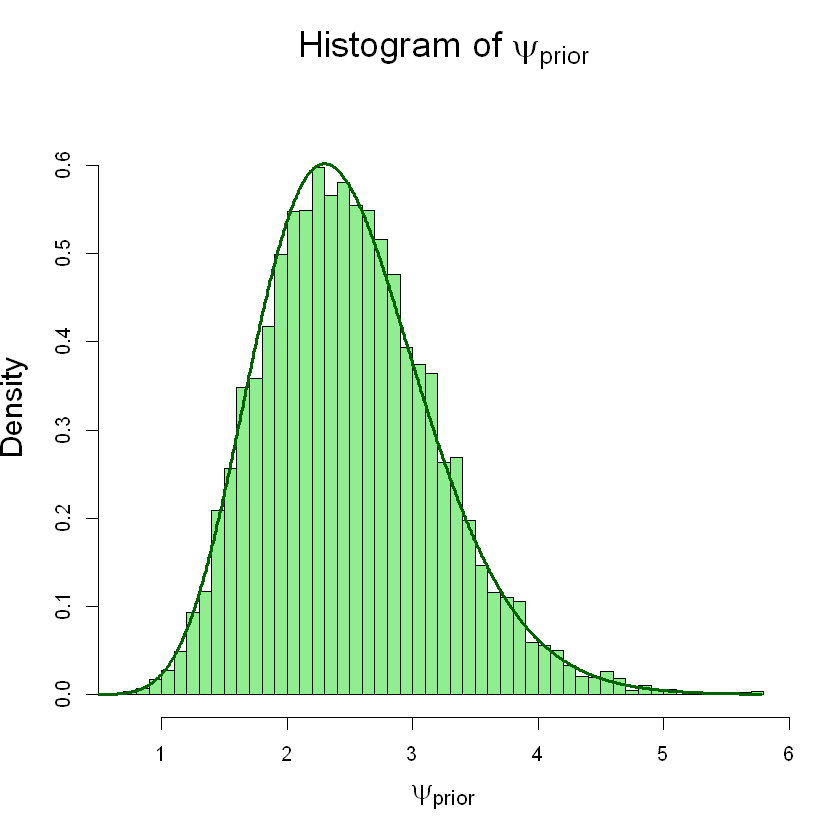

In [16]:
# Plot histogram, compare with the theoretical Gamma pdf 
options(repr.plot.width=7,repr.plot.height=7)
hist(psi.prior,freq=FALSE,col="LightGreen",
     xlab=expression(psi[prior]),
     main=expression(paste("Histogram of ",psi[prior])),
     ylim=c(0,0.65),breaks=50,cex.lab=1.5,cex.main=1.8)
v<-seq(0,max(psi.prior),length=1000)
lines(v,dgamma(v,shape=prior.a,rate=prior.b),lwd=3,col="DarkGreen")

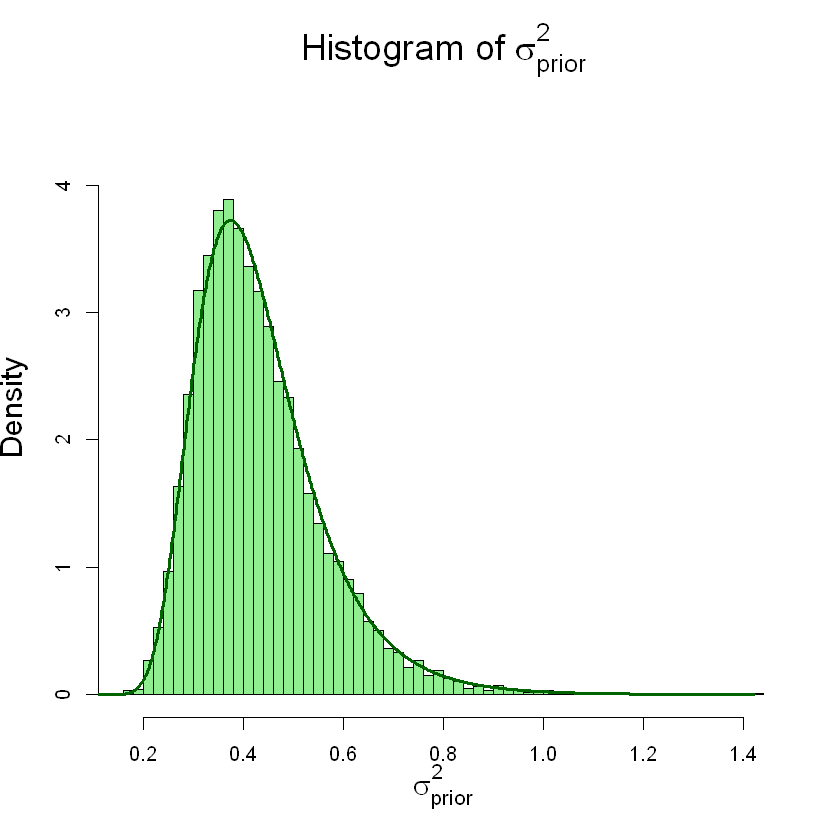

In [17]:
# Plot histogram, compare with the theoretical IG pdf 
require(extraDistr,quietly=TRUE)
options(repr.plot.width=7,repr.plot.height=7)
hist(sigma.prior^2,freq=FALSE,col="LightGreen",
     xlab=expression(sigma[prior]^2),
     main=expression(paste("Histogram of ",sigma[prior]^2)),
     ylim=c(0,4.5),breaks=47,cex.lab=1.5,cex.main=1.8)
v<-seq(0,max(sigma.prior^2),length=1000)
lines(v,dinvgamma(v,alpha=prior.a,beta=prior.b),lwd=3,col="DarkGreen")

## 02. Simulate from the prior predictive pdf

The `model` block still does not contain a likelihood but now there is a `generated quantities` block.

In [18]:
modelString.prior.pred = "data {
    real<lower=0> a;     
    real<lower=0> b;
    real mu;
    }
parameters {
    real<lower=0> psi;
    }
transformed parameters {
     real<lower=0> sigma = inv_sqrt(psi);
    }
model {
    // prior
    psi ~ gamma(a, b); 
    }
generated quantities {
    real x_pred;

// prediction
    x_pred = normal_rng(mu, sigma);  // Stan uses same normal parameterization as R
    }
"

In [19]:
# Translate model to C++ and compile to DSO:
stanDso.prior.pred <- stan_model(model_code=modelString.prior.pred) 

In [20]:
# Specify data:
mu<--2.5
dataList.prior.pred = list(a=prior.a,b=prior.b,mu=mu)

In [21]:
# Generate posterior sample:
stanFit.prior.pred<-sampling(object=stanDso.prior.pred,data=dataList.prior.pred,
                             chains=3,iter=10000,warmup=1500,thin=5)

In [22]:
S.prior.pred<-summary(stanFit.prior.pred)
round(S.prior.pred$summary,4)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
psi,2.4984,0.0100,0.6884,1.3361,2.0021,2.4415,2.9289,3.9840,4733.270,0.9997
sigma,0.6515,0.0014,0.0942,0.5010,0.5843,0.6400,0.7067,0.8651,4622.500,0.9996
x_pred,-2.5024,0.0097,0.6576,-3.7914,-2.9286,-2.5070,-2.0879,-1.2113,4572.617,1.0002
lp__,-1.6729,0.0104,0.7206,-3.6909,-1.8460,-1.4001,-1.2125,-1.1636,4833.046,0.9999


In [23]:
# extract prior sample, discard unnecessary attributes to keep just the numbers
x_prior.pred <- extract(stanFit.prior.pred, 'x_pred')
x_prior.pred <- unlist(x_prior.pred, use.names=FALSE)
str(x_prior.pred)

 num [1:5100] -2.59 -2.07 -1.96 -1.83 -2.95 ...


In [24]:
# center the sample (to compare with the theoretical pdf)
x_prior.pred.0<-x_prior.pred-mu
str(x_prior.pred.0)

 num [1:5100] -0.0926 0.4323 0.5384 0.6723 -0.4531 ...


In [25]:
round(mean(x_prior.pred.0),3)
round(var(x_prior.pred.0),3)
round(sd(x_prior.pred.0),3)

[1] -0.002

[1] 0.432

[1] 0.658

In [26]:
n.0<-1
k.0<-2*prior.a+n.0-1
round(k.0,4)
c0<-sqrt(k.0*n.0/(2*prior.b))
round(c0,4)
Stan.sim.t<-c0*x_prior.pred.0

[1] 26.4296

[1] 1.5777

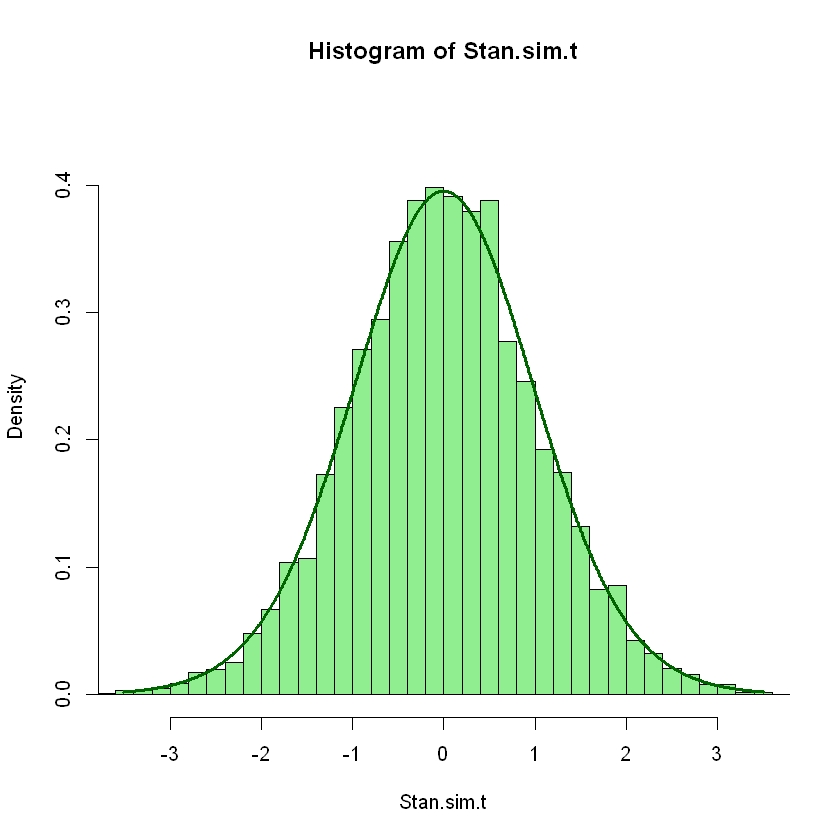

In [27]:
# Plot histogram, 
options(repr.plot.width=7,repr.plot.height=7)
tmax<-0.7*max(max(Stan.sim.t),-min(Stan.sim.t))
hist(Stan.sim.t,freq=FALSE,col="LightGreen",xlim=c(-tmax,tmax),ylim=c(0,0.45),breaks=40)
u<-seq(-tmax,tmax,length=1000)
yu<-dt(u,df=k.0)
lines(u,yu,lwd=2.5,col="DarkGreen")

## 03. Simulate from the posterior pdf

The `model` block now has a likelihood but there is no `generated quantities` block.

In [28]:
modelString.post = "data {
    real<lower=0> a;     
    real<lower=0> b;
    int<lower=1> n;
    real x[n];
    real mu;
    }
parameters {
    real<lower=0> psi;
    }
transformed parameters {
    real<lower=0> sigma = inv_sqrt(psi);
    }
model {
    // prior
    psi ~ gamma(a, b); 
    //likelihood
    x ~ normal(mu, sigma);   // vectorized likelihood statement
    }
"

In [29]:
# Translate model to C++ and compile to DSO:
stanDso.post <- stan_model(model_code=modelString.post) 

In [30]:
# Logs of concentration of mercury in fish tissue
x<-c(-2.526, -1.715, -1.427, -2.12, -2.659, -2.408, -3.219, -1.966,-2.526, -1.833,
    -2.813, -1.772, -2.813, -2.526, -3.219, -2.526,-2.813, -2.526, -3.507, -2.996, -3.912)
n<-length(x)
n

[1] 21

In [31]:
# Specify data:
mu<--2.5
dataList.post = list(a=prior.a,b=prior.b,mu=mu,x=x,n=n)

In [32]:
# Generate posterior sample:
stanFit.post<-sampling(object=stanDso.post,data=dataList.post,chains=3,iter=10000,warmup=1500,thin=1)

In [33]:
S.post<-summary(stanFit.post)
round(S.post$summary,4)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
psi,2.5791,0.0056,0.5268,1.6609,2.2054,2.5391,2.9122,3.7156,8894.507,1.0006
sigma,0.6326,0.0007,0.0659,0.5188,0.5860,0.6276,0.6734,0.7759,8547.952,1.0007
lp__,-1.7664,0.0064,0.6982,-3.7968,-1.9298,-1.4972,-1.3211,-1.2704,11957.363,1.0002


In [34]:
# extract posterior sample, discard unnecessary attributes to keep just the numbers
psi.post <- extract(stanFit.post, 'psi')
psi.post <- unlist(psi.post, use.names=FALSE)
str(psi.post)

 num [1:25500] 2.96 2.95 2.88 3.04 2.76 ...


In [35]:
# extract posterior sample, discard unnecessary attributes to keep just the numbers
sigma.post <- extract(stanFit.post, 'sigma')
sigma.post <- unlist(sigma.post, use.names=FALSE)
str(sigma.post)

 num [1:25500] 0.581 0.582 0.59 0.574 0.602 ...


In [36]:
post.a<-prior.a+n/2
post.b<-prior.b+n*s20/2
round(post.a,4)
round(post.b,4)

[1] 23.7148

[1] 9.2041

[1] 2.4689

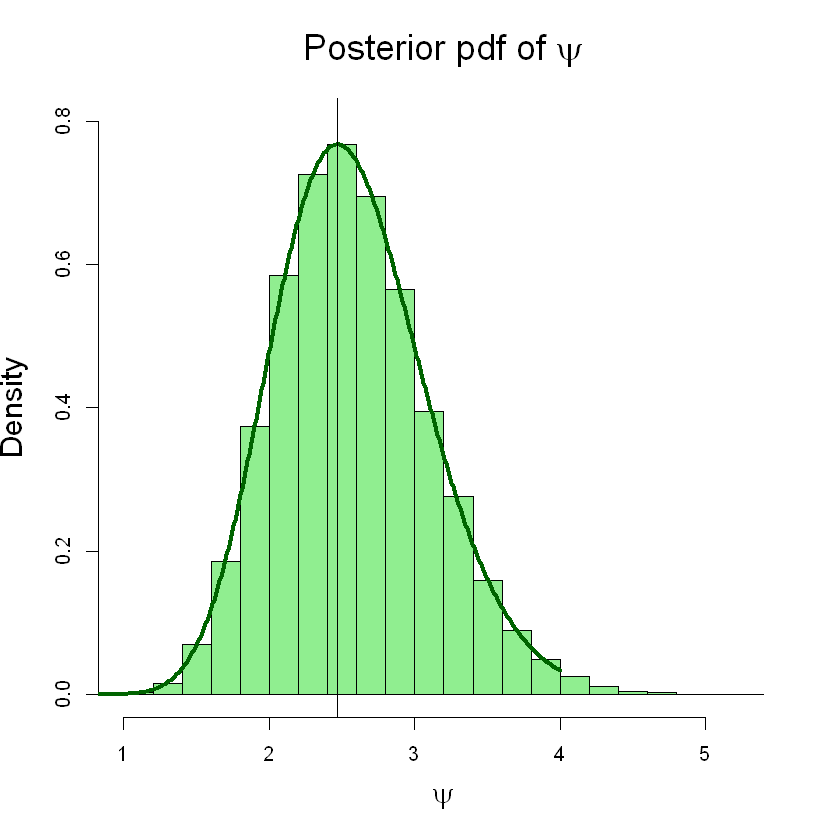

In [37]:
options(repr.plot.width=7,repr.plot.height=7)
hist(psi.post,freq=FALSE,col="LightGreen",ylim=c(0,0.8),breaks=30,
     xlab=expression(psi),
     ylab="Density",
     main=expression(paste("Posterior pdf of ",psi)),
     cex.lab=1.5,cex.main=1.8)
# Theoretical posterior pdf
pdf<-function(x){dgamma(x,shape=post.a,rate=post.b)}
u<-seq(0,4,length=500)
lines(u,pdf(u),lwd=3.5,col="DarkGreen")
# Theoretical MAP
MAP.psi<-u[which.max(pdf(u))]
round(MAP.psi,4)
abline(v=MAP.psi,lwd=1.5,col="black")

[1] 0.3725

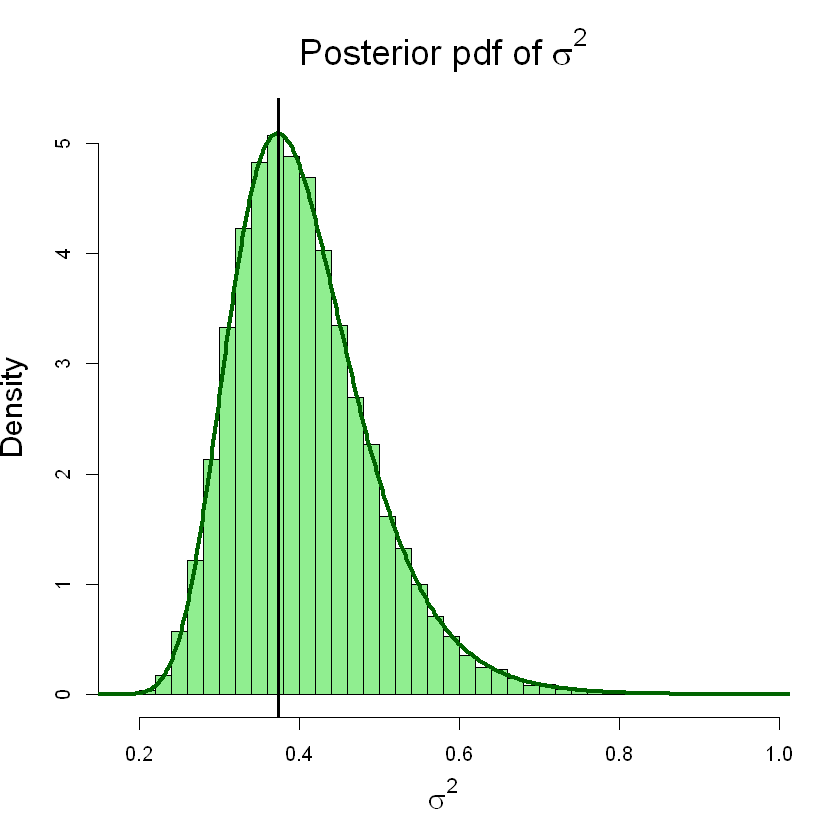

In [38]:
options(repr.plot.width=7,repr.plot.height=7)
hist(sigma.post^2,freq=FALSE,col="LightGreen",
     ylim=c(0,5.2),breaks=40,
     xlab=expression(sigma^2),
     ylab="Density",
     main=expression(paste("Posterior pdf of ",sigma^2)),
     cex.lab=1.5,cex.main=1.8)
# Theoretical posterior pdf
pdf<-function(x){dinvgamma(x,alpha=post.a,beta=post.b)}
u<-seq(0,1.1,length=500)
lines(u,pdf(u),lwd=3.5,col="DarkGreen")
# Theoretical MAP
MAP.sigma2<-u[which.max(pdf(u))]
round(MAP.sigma2,4)
abline(v=MAP.sigma2,lwd=2.5,col="black")

## 04. Simulate from the posterior predictive pdf

Now both the `model` block does contain a likelihood and there is a `generated quantities` block.

In [39]:
modelString.post.pred = "data {
    real<lower=0> a;     
    real<lower=0> b;
    int<lower=1> n;
    real x[n];
    real mu;
    }
parameters {
    real<lower=0> psi;
    }
transformed parameters {
    real<lower=0> sigma = inv_sqrt(psi);
    }
model {
    // prior
    psi ~ gamma(a, b); 
    //likelihood
    x ~ normal(mu, sigma);
    }
generated quantities {
    real x_pred;

// prediction
    x_pred = normal_rng(mu, sigma);
    }
"

In [40]:
# Translate model to C++ and compile to DSO:
stanDso.post.pred <- stan_model(model_code=modelString.post.pred) 

In [41]:
# Logs of concentration of mercury in fish tissue
x<-c(-2.526, -1.715, -1.427, -2.12, -2.659, -2.408, -3.219, -1.966,-2.526, -1.833,
    -2.813, -1.772, -2.813, -2.526, -3.219, -2.526,-2.813, -2.526, -3.507, -2.996, -3.912)
n<-length(x)
n

[1] 21

In [42]:
# Specify data:
mu<--2.5
dataList.post.pred = list(a=prior.a,b=prior.b,mu=mu,x=x,n=n)

In [43]:
# Generate posterior sample:
stanFit.post.pred<-sampling(object=stanDso.post.pred,data=dataList.post.pred,
                             chains=3,iter=10000,warmup=1500,thin=5)

In [44]:
S.post.pred<-summary(stanFit.post.pred)
round(S.post.pred$summary,4)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
psi,2.5770,0.0077,0.5379,1.6328,2.1984,2.5389,2.9124,3.7500,4862.488,1.0003
sigma,0.6334,0.0010,0.0680,0.5164,0.5860,0.6276,0.6745,0.7826,4970.518,1.0002
x_pred,-2.5162,0.0089,0.6509,-3.8126,-2.9525,-2.5164,-2.0756,-1.2308,5403.095,0.9998
lp__,-1.7911,0.0104,0.7547,-3.8605,-1.9430,-1.5016,-1.3217,-1.2704,5284.086,0.9996


In [45]:
# extract prior sample, discard unnecessary attributes to keep just the numbers
x_post.pred <- extract(stanFit.post.pred, 'x_pred')
x_post.pred <- unlist(x_post.pred, use.names=FALSE)
str(x_post.pred)

 num [1:5100] -2.29 -2.53 -2 -2.63 -2.18 ...


In [46]:
# center the sample (to compare with the theoretical pdf)
x_post.pred.0<-x_post.pred-mu
str(x_post.pred.0)

 num [1:5100] 0.2148 -0.0336 0.502 -0.1322 0.3213 ...


In [47]:
round(mean(x_post.pred.0),3)
round(var(x_post.pred.0),3)
round(sd(x_post.pred.0),3)

[1] -0.016

[1] 0.424

[1] 0.651

In [48]:
n.1<-1 # sample size for posterior prediction
k.1<-2*post.a+n.1-1
round(k.1,4)
c1<-sqrt(k.1*n.1/(2*post.b))
round(c1,4)
Stan.post.t<-c0*x_post.pred.0

[1] 47.4296

[1] 1.6052

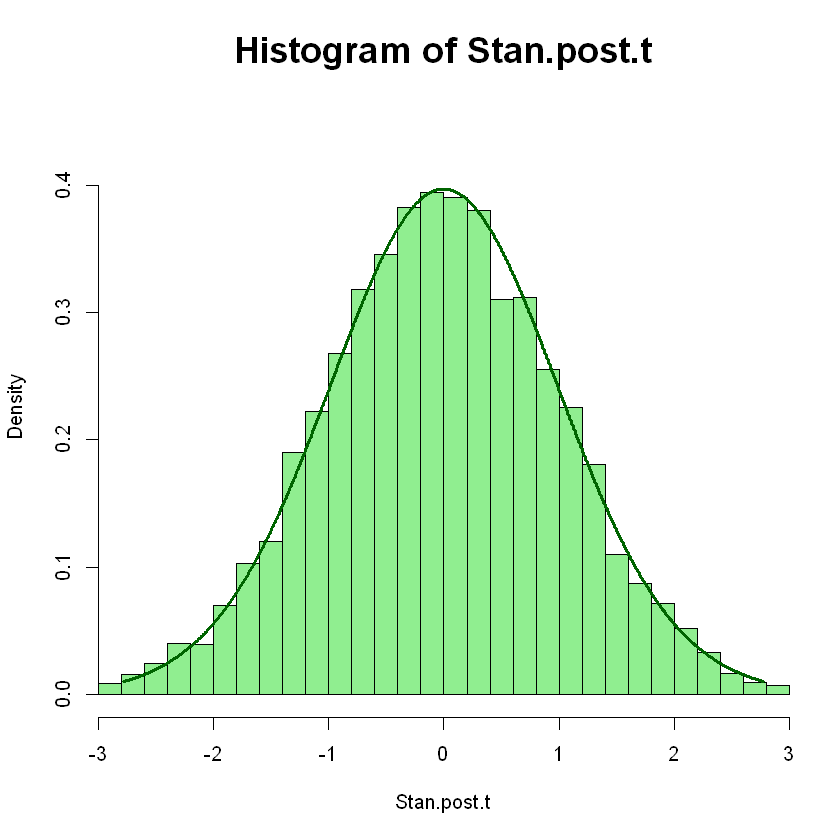

In [49]:
# Plot histogram, superimposing the theoretical Student t distribution, with k.1 degrees of freedom
options(repr.plot.width=7,repr.plot.height=7)
tmax<-0.7*max(max(Stan.post.t),-min(Stan.post.t))
hist(Stan.post.t,freq=FALSE,col="LightGreen",xlim=c(-tmax,tmax),ylim=c(0,0.45),breaks=40,
    cex.main=1.8)
u<-seq(-tmax,tmax,length=1000)
yu<-dt(u,df=k.1)
lines(u,yu,lwd=2.5,col="DarkGreen")